In [2]:
import h5py
import numpy as np
from gwpy.timeseries import TimeSeries
import bilby
import bilby_pipe
from pesummary.io import read
import os
import sys
#sys.path.append("../vitamin_c/")
model_dir = "/home/joseph.bayley/public_html/CBC/vitamin_O4MDC/vitamin_c_run2_1024_16ynorm/"
sys.path.append(model_dir)
from vitamin_c_model_fit import CVAE
sys.path.append("../vitamin_c/")
from vitamin_c_fit import get_params
sys.path.append("../notebooks")
from test_on_o4 import plot_posterior_n
#import load_data
import load_data_fit
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.signal as signal
import corner
import random
from astropy.time import Time
from astropy import coordinates as coord
import gen_benchmark_pe

In [3]:
%matplotlib inline

In [5]:
REFERENCE_FREQUENCY = 20
MINIMUM_FREQUENCY = 20
SAMPLING_FREQUENCY = 16384
MAX_SIGNAL = 128
DURATION = 1024 + MAX_SIGNAL
TREF = 1325030418
THALFWINDOW = 0.1

ref_geocent_time = TREF
duration = 1

In [6]:
start_time = ref_geocent_time-duration/2.0

In [7]:
asd_file = "/home/joseph.bayley/projects/o4_online_pe_mdc/data/asd_files/aLIGO_O4_high_asd.txt"
asd_files = bilby_pipe.utils.convert_string_to_dict('{{"H1": {0}, "L1": {0}}}'.format(asd_file))
interferometers = asd_files.keys()

In [8]:
priors = bilby.gw.prior.BBHPriorDict()
priors.pop("chirp_mass")

02:23 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)

In [9]:
priors

{'mass_1': Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None),
 'mass_ratio': Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'luminosity_distance': UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None),
 'dec': Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None),
 'ra': Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic'),
 'theta_jn': Sine(minimum=0, maximum=3.141592653589793, name='theta_jn', latex_label='$\\theta_{JN}$', unit=None, boundary=None),
 'p

In [10]:
priors['geocent_time'] = bilby.core.prior.Uniform(
                minimum=ref_geocent_time + 0.15,
                maximum=ref_geocent_time + 0.35,
                name='geocent_time', latex_label='$t_c$', unit='$s$')

priors['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=5, maximum=100,unit='$M_{\odot}$')
priors['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=5, maximum=100,unit='$M_{\odot}$')
"""
priors['a_1'] = bilby.gw.prior.Uniform(name='a_1', minimum=bounds['a_1_min'], maximum=bounds['a_1_max'])
priors['a_2'] = bilby.gw.prior.Uniform(name='a_2', minimum=bounds['a_2_min'], maximum=bounds['a_2_max'])
priors['tilt_1'] = bilby.core.prior.Sine(name='tilt_1', minimum=bounds['tilt_1_min'], maximum=bounds['tilt_1_max'])
priors['tilt_2'] = bilby.core.prior.Sine(name='tilt_2', minimum=bounds['tilt_2_min'], maximum=bounds['tilt_2_max'])
priors['phi_12'] = bilby.gw.prior.Uniform(name='phi_12', minimum=bounds['phi_12_min'], maximum=bounds['phi_12_max'], boundary='periodic')
priors['phi_jl'] = bilby.gw.prior.Uniform(name='phi_jl', minimum=bounds['phi_jl_min'], maximum=bounds['phi_jl_max'], boundary='periodic')
priors['ra'] = bilby.gw.prior.Uniform(name='ra', minimum=bounds['ra_min'], maximum=bounds['ra_max'], boundary='periodic')
priors['psi'] = bilby.gw.prior.Uniform(name='psi', minimum=bounds['psi_min'], maximum=bounds['psi_max'], boundary='periodic')
priors['phase'] = bilby.gw.prior.Uniform(name='phase', minimum=bounds['phase_min'], maximum=bounds['phase_max'], boundary='periodic')
priors['luminosity_distance'] =  bilby.gw.prior.Uniform(name='luminosity_distance', minimum=bounds['luminosity_distance_min'], maximum=bounds['luminosity_dista\
nce_max'], unit='Mpc')
"""

"\npriors['a_1'] = bilby.gw.prior.Uniform(name='a_1', minimum=bounds['a_1_min'], maximum=bounds['a_1_max'])\npriors['a_2'] = bilby.gw.prior.Uniform(name='a_2', minimum=bounds['a_2_min'], maximum=bounds['a_2_max'])\npriors['tilt_1'] = bilby.core.prior.Sine(name='tilt_1', minimum=bounds['tilt_1_min'], maximum=bounds['tilt_1_max'])\npriors['tilt_2'] = bilby.core.prior.Sine(name='tilt_2', minimum=bounds['tilt_2_min'], maximum=bounds['tilt_2_max'])\npriors['phi_12'] = bilby.gw.prior.Uniform(name='phi_12', minimum=bounds['phi_12_min'], maximum=bounds['phi_12_max'], boundary='periodic')\npriors['phi_jl'] = bilby.gw.prior.Uniform(name='phi_jl', minimum=bounds['phi_jl_min'], maximum=bounds['phi_jl_max'], boundary='periodic')\npriors['ra'] = bilby.gw.prior.Uniform(name='ra', minimum=bounds['ra_min'], maximum=bounds['ra_max'], boundary='periodic')\npriors['psi'] = bilby.gw.prior.Uniform(name='psi', minimum=bounds['psi_min'], maximum=bounds['psi_max'], boundary='periodic')\npriors['phase'] = bilby

In [11]:
pars = priors.sample()

In [24]:
pars["luminosity_distance"] = 700

In [25]:
injection_parameters = dict(
        mass_1=pars['mass_1'],mass_2=pars['mass_2'], a_1=pars['a_1'], a_2=pars['a_2'], tilt_1=pars['tilt_1'], tilt_2=pars['tilt_2'],
        phi_12=pars['phi_12'], phi_jl=pars['phi_jl'], luminosity_distance=pars['luminosity_distance'], theta_jn=pars['theta_jn'], psi=pars['psi'],
        phase=pars['phase'], geocent_time=pars['geocent_time'], ra=pars['ra'], dec=pars['dec'])

In [26]:
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                              reference_frequency=20., minimum_frequency=20.)

In [27]:
sampling_frequency1 = 16384
sampling_frequency2 = 1024

In [28]:
waveform_generator1 = bilby.gw.WaveformGenerator(
        duration=duration, sampling_frequency=sampling_frequency1,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
        start_time=start_time)

waveform_generator2 = bilby.gw.WaveformGenerator(
        duration=duration, sampling_frequency=sampling_frequency2,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
        start_time=start_time)

02:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
02:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [29]:
det = ["H1","L1"]
ifos1 = bilby.gw.detector.InterferometerList(det)
ifos2 = bilby.gw.detector.InterferometerList(det)

In [30]:
asd_file = "/home/joseph.bayley/projects/o4_online_pe_mdc/data/asd_files/aLIGO_O4_high_asd.txt"
ifos1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file=asd_file)
ifos2.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file=asd_file)

In [31]:
ifos1.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency1, duration=duration,
    start_time=start_time)
ifos2.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency2, duration=duration,
    start_time=start_time)

/home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/detector/psd.py:362: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


In [32]:
ifos1.inject_signal(waveform_generator=waveform_generator1,
                       parameters=injection_parameters)

ifos2.inject_signal(waveform_generator=waveform_generator2,
                       parameters=injection_parameters)

02:24 bilby INFO    : Injected signal in H1:
02:24 bilby INFO    :   optimal SNR = 28.73
02:24 bilby INFO    :   matched filter SNR = 27.98-1.50j
02:24 bilby INFO    :   mass_1 = 34.53069931012032
02:24 bilby INFO    :   mass_2 = 41.551707905050876
02:24 bilby INFO    :   a_1 = 0.07402520633343301
02:24 bilby INFO    :   a_2 = 0.2154869177833085
02:24 bilby INFO    :   tilt_1 = 1.283126838672844
02:24 bilby INFO    :   tilt_2 = 1.8897956709646766
02:24 bilby INFO    :   phi_12 = 2.8915757295321853
02:24 bilby INFO    :   phi_jl = 5.88461810756219
02:24 bilby INFO    :   luminosity_distance = 700
02:24 bilby INFO    :   theta_jn = 0.3143250294306462
02:24 bilby INFO    :   psi = 2.3710034758046517
02:24 bilby INFO    :   phase = 0.45992481069279584
02:24 bilby INFO    :   geocent_time = 1325030418.229045
02:24 bilby INFO    :   ra = 1.7232773149333294
02:24 bilby INFO    :   dec = 0.007110168334856837
02:24 bilby INFO    : Injected signal in L1:
02:24 bilby INFO    :   optimal SNR = 23.

[{'plus': array([ 0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -9.31777786e-29+2.64587129e-28j,
         -9.42597326e-29+2.56300304e-28j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         2.64278579e-28+9.31470190e-29j,
         2.56000478e-28+9.42254466e-29j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': array([ 0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -9.31777786e-29+2.64587129e-28j,
         -9.42597326e-29+2.56300304e-28j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         2.64278579e-28+9.31470190e-29j,
         2.56000478e-28+9

In [34]:
ifos11 = bilby.gw.detector.InterferometerList(det)
ifos21 = bilby.gw.detector.InterferometerList(det)
ifos31 = bilby.gw.detector.InterferometerList(det)

In [147]:
itest = ifos21[i]

In [155]:
itest.set_strain_data_from_gwpy_timeseries?

Signature: itest.set_strain_data_from_gwpy_timeseries(time_series)
Docstring:
Set the `Interferometer.strain_data` from a gwpy TimeSeries

Parameters
time_series: gwpy.timeseries.timeseries.TimeSeries
    The data to set.
File:      ~/.local/lib/python3.7/site-packages/bilby/gw/detector/interferometer.py
Type:      method


In [149]:
TimeSeries?

Init signature:
TimeSeries(
    data,
    unit=None,
    t0=None,
    dt=None,
    sample_rate=None,
    times=None,
    channel=None,
    name=None,
    **kwargs,
)
Docstring:     
A time-domain data array.

Parameters
----------
value : array-like
    input data array

unit : `~astropy.units.Unit`, optional
    physical unit of these data

t0 : `~gwpy.time.LIGOTimeGPS`, `float`, `str`, optional
    GPS epoch associated with these data,
    any input parsable by `~gwpy.time.to_gps` is fine

dt : `float`, `~astropy.units.Quantity`, optional
    time between successive samples (seconds), can also be given inversely
    via `sample_rate`

sample_rate : `float`, `~astropy.units.Quantity`, optional
    the rate of samples per second (Hertz), can also be given inversely
    via `dt`

times : `array-like`
    the complete array of GPS times accompanying the data for this series.
    This argument takes precedence over `t0` and `dt` so should be given
    in place of these if relevant, not al

In [35]:
trigger_time = 1325030418.015282
end_load = trigger_time + 0.25 #+1
duration = 1
start_load = end_load - duration
start_time1 = start_load + 1
end_time1 = start_load + 2
for i in range(len(det)):
    #resamp1 = signal.decimate(ifos[i].strain_data.time_domain_strain   , int(4))
    #resamp2 = signal.decimate(resamp1, int(4))
    #ts = TimeSeries(resamp2, sample_rate = 1024)
    #ts = ts.crop(start=1, end = 2, copy = True)
    
    ts = TimeSeries(ifos1[i].strain_data.time_domain_strain, sample_rate = 16384)
    
    ts_1 = ts.resample(1024)
    #ts_resamp = ts_resamp.crop(start = start_time, end = end_time)
    ifos11[i].set_strain_data_from_gwpy_timeseries(ts_1)
    
    ts_2 = TimeSeries(ifos2[i].strain_data.time_domain_strain, sample_rate = 1024)
    
    ifos21[i].set_strain_data_from_gwpy_timeseries(ts_2)

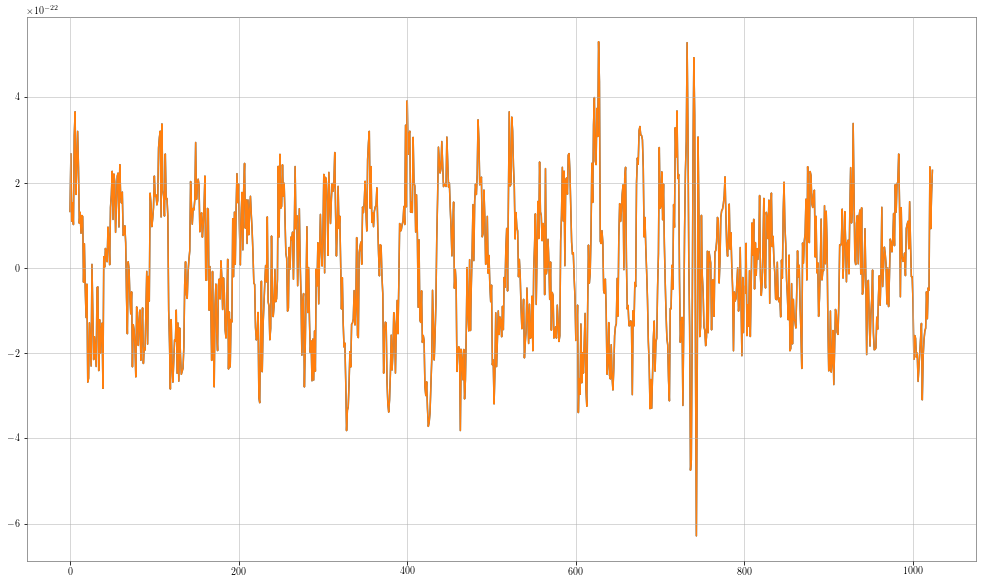

In [36]:
fig, ax = plt.subplots(figsize = (17,10))
ax.plot(ifos2[i].strain_data.time_domain_strain)
ax.plot(ts_2.value)

In [44]:
Nt1 = int(sampling_frequency2*duration)
Nt2 = int(sampling_frequency2*duration)
whitened_h_td_all1 = []
whitened_h_td_all2 = []
whitened_h_td_all3 = []
for i in range(len(det)):

    h_fd1, fa1 = bilby.utils.nfft(ifos11[0].strain_data.time_domain_strain, ifos11[0].strain_data.sampling_frequency)
    h_fd2, fa2 = bilby.utils.nfft(ifos21[0].strain_data.time_domain_strain, ifos21[0].strain_data.sampling_frequency)
    #h_fd3, fa3 = bilby.utils.nfft(ifos2[0].strain_data.time_domain_strain * ifos2[0].strain_data.time_domain_window(), ifos2[0].strain_data.sampling_frequency)
    
    #h_fd1 = ifos11[0].strain_data.frequency_domain_strain 
    #h_fd2 = ifos21[0].strain_data.frequency_domain_strain
    h_fd3 = ifos2[0].strain_data.frequency_domain_strain
    
    whitened_h_fd1 = h_fd1/ifos11[i].amplitude_spectral_density_array
    whitened_h_fd2 = h_fd2/ifos21[i].amplitude_spectral_density_array
    whitened_h_fd3 = h_fd3/ifos2[i].amplitude_spectral_density_array
    
    whitened_h_td1 = np.sqrt(2.0*Nt1)*np.fft.irfft(whitened_h_fd1)
    whitened_h_td2 = np.sqrt(2.0*Nt2)*np.fft.irfft(whitened_h_fd2)
    whitened_h_td3 = np.sqrt(2.0*Nt2)*np.fft.irfft(whitened_h_fd3)
    
    whitened_h_td_all1.append([whitened_h_td1/16])
    whitened_h_td_all2.append([whitened_h_td2/16])
    whitened_h_td_all3.append([whitened_h_td3/16])

/home/joseph.bayley/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/joseph.bayley/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


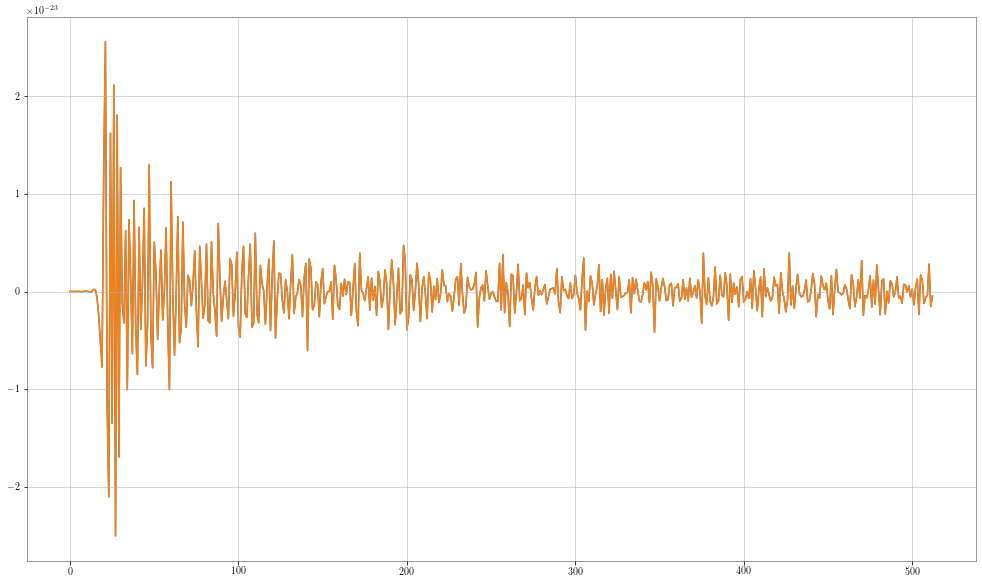

In [38]:
fig, ax = plt.subplots(figsize = (17,10))
fd1, fa1 = bilby.utils.nfft(ifos2[0].strain_data.time_domain_strain * ifos2[0].strain_data.time_domain_window(), ifos2[0].strain_data.sampling_frequency)
fd2, fa2 = bilby.utils.nfft(ifos21[0].strain_data.time_domain_strain * ifos21[0].strain_data.time_domain_window(), ifos21[0].strain_data.sampling_frequency)
ax.plot(fd1)
ax.plot(fd2)

In [120]:
pars["det"] = ["H1","L1"]
wh_sig_all, wh_h_all, inj_par, ifo_t, wf_gen_t = gen_benchmark_pe.gen_template(1, 1024, pars, ref_geocent_time, psd_files = [asd_file,asd_file])

09:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
09:15 bilby INFO    : Injected signal in H1:
09:15 bilby INFO    :   optimal SNR = 7.10
09:15 bilby INFO    :   matched filter SNR = 5.87+0.34j
09:15 bilby INFO    :   mass_1 = 89.35936981910986
09:15 bilby INFO    :   mass_2 = 65.87714408232807
09:15 bilby INFO    :   a_1 = 0.5510452855171772
09:15 bilby INFO    :   a_2 = 0.5718292850551121
09:15 bilby INFO    :   tilt_1 = 0.8929457705613897
09:15 bilby INFO    :   tilt_2 = 1.9761681924297196
09:15 bilby INFO    :   phi_12 = 1.5094772961858778
09:15 bilby INFO    :   phi_jl = 5.9765636015199215
09:15 bilby INFO    :   luminosity_distance = 1000
09:15 bilby INFO    :   theta_jn = 2.6850738640100658
09:15 bilby INFO    :   psi = 0.2638338817549855
09:15 bilby INFO    :   phase = 2.775082112862

... Injected signal
... Whitened signals


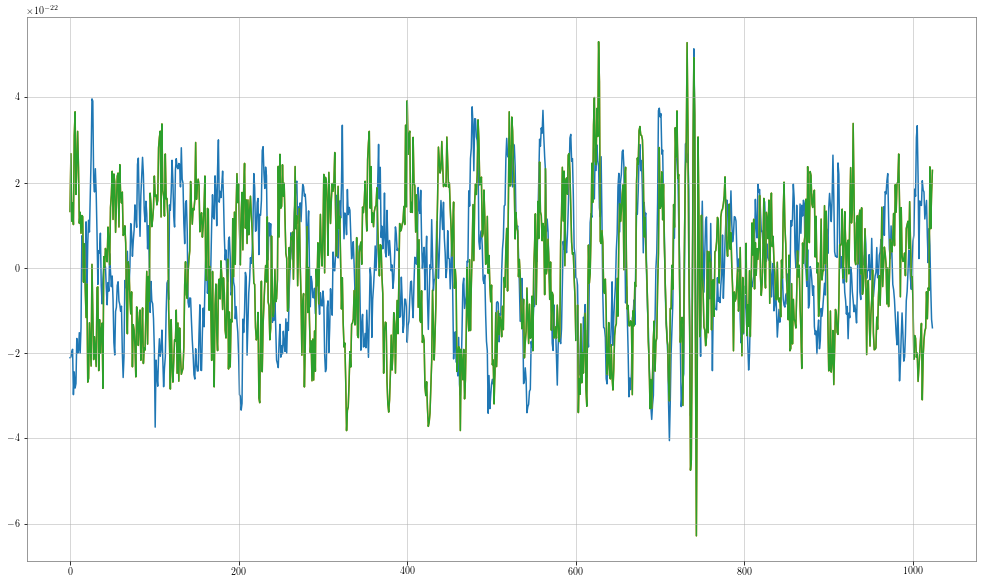

In [53]:
fig, ax = plt.subplots(figsize = (17,10))
#ax.plot(whitened_h_td_all1[0][0])
ax.plot(ifos11[i].strain_data.time_domain_strain)
ax.plot(ifos21[i].strain_data.time_domain_strain)
ax.plot(ifos2[i].strain_data.time_domain_strain)
#ax.plot(wh_h_all[0]/16)

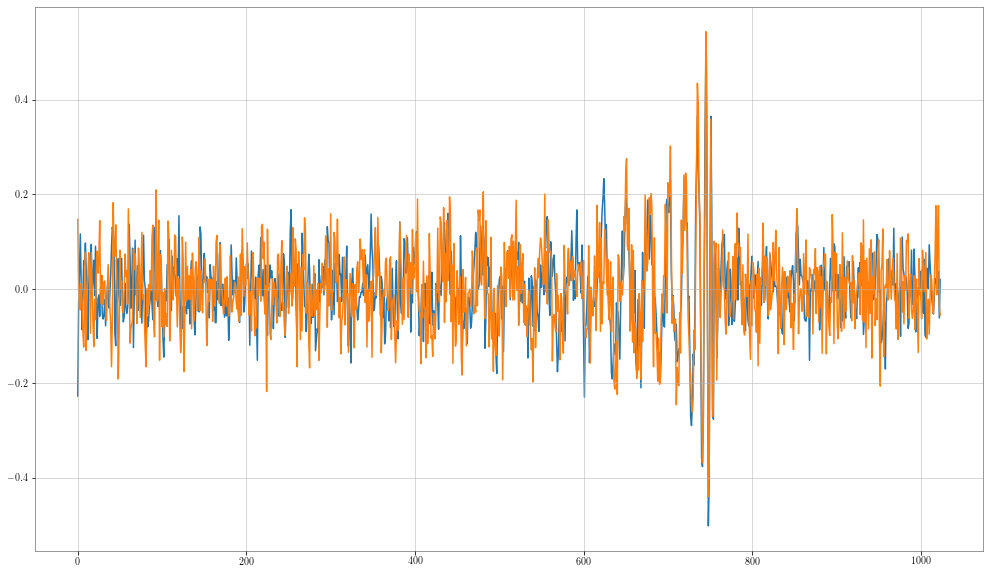

In [50]:
fig, ax = plt.subplots(figsize = (17,10))
ax.plot(whitened_h_td_all1[0][0])
#ax.plot(whitened_h_td_all2[0][0])
ax.plot(whitened_h_td_all3[0][0])
#ax.plot(whitened_h_td_all3[0][0] - whitened_h_td_all1[0][0])
#ax.plot(wh_h_all[0]/16)

In [219]:
trigger_time = 1325030418.015282
end_load = trigger_time + 0.25 + 1
duration = 3
start_load = end_load - duration
start_time = start_load + 1
end_time = start_load + 2
for i in range(len(det)):
    #resamp1 = signal.decimate(ifos[i].strain_data.time_domain_strain   , int(4))
    #resamp2 = signal.decimate(resamp1, int(4))
    #ts = TimeSeries(resamp2, sample_rate = 1024)
    #ts = ts.crop(start=1, end = 2, copy = True)
    
    data_dir = "/home/joseph.bayley/data/CBC/O4MDC/o4_online/U1/"
    file_name = os.path.join(data_dir,"{}-O4MDC-1325029268-1152.gwf".format(det[i]))
    channel_name = "{}:O4MDC".format(det[i])

    # load timeseries from start to end time for signal                                                                                                             
    ts = TimeSeries.read(file_name,channel_name, start = start_load, end = end_load)
    
    #ts = TimeSeries(ifos[i].strain_data.time_domain_strain, sample_rate = 16384)
    
    ts_resamp = ts.resample(1024)
    #ts_resamp = ts_resamp.crop(start = start_time, end = end_time)
    ifos2[i].set_strain_data_from_gwpy_timeseries(ts_resamp)
    
for i in range(len(det)):
    #resamp1 = signal.decimate(ifos[i].strain_data.time_domain_strain   , int(4))
    #resamp2 = signal.decimate(resamp1, int(4))
    #ts = TimeSeries(resamp2, sample_rate = 1024)
    #ts = ts.crop(start=1, end = 2, copy = True)
    
    data_dir = "/home/joseph.bayley/data/CBC/O4MDC/o4_online/U1/"
    file_name = os.path.join(data_dir,"{}-O4MDC-1325029268-1152.gwf".format(det[i]))
    channel_name = "{}:O4MDC".format(det[i])

    # load timeseries from start to end time for signal                                                                                                             
    ts = TimeSeries.read(file_name,channel_name, start = start_load, end = end_load)
    
    #ts = TimeSeries(ifos[i].strain_data.time_domain_strain, sample_rate = 16384)
    
    ts_resamp = ts.resample(1024)
    ts_resamp = ts_resamp.crop(start = start_time, end = end_time)
    ifos3[i].set_strain_data_from_gwpy_timeseries(ts_resamp)

In [220]:
Nt = int(sampling_frequency*duration)
whitened_h_td_all = []
whitened_h_td_all3 = []
for i in range(len(det)):
    
    h_fd = ifos2[i].strain_data.frequency_domain_strain
    h_fd3 = ifos3[i].strain_data.frequency_domain_strain
    
    whitened_h_fd = h_fd/ifos2[i].amplitude_spectral_density_array
    whitened_h_fd3 = h_fd3/ifos3[i].amplitude_spectral_density_array
    
    whitened_h_td = np.sqrt(2.0*Nt)*np.fft.irfft(whitened_h_fd)
    whitened_h_td3 = np.sqrt(2.0*Nt)*np.fft.irfft(whitened_h_fd3)
    
    print(len(whitened_h_td))
    whitened_h_td_all.append([whitened_h_td[1024:2048]/16])
    whitened_h_td_all3.append([whitened_h_td3/16])

06:10 bilby INFO    : Generating frequency domain strain from given time domain strain.
06:10 bilby INFO    : Applying a tukey window with alpha=0.13333333333333333, roll off=0.2
06:10 bilby INFO    : Generating frequency domain strain from given time domain strain.
06:10 bilby INFO    : Applying a tukey window with alpha=0.4, roll off=0.2
06:10 bilby INFO    : Generating frequency domain strain from given time domain strain.
06:10 bilby INFO    : Applying a tukey window with alpha=0.13333333333333333, roll off=0.2
06:10 bilby INFO    : Generating frequency domain strain from given time domain strain.
06:10 bilby INFO    : Applying a tukey window with alpha=0.4, roll off=0.2


3072
3072


In [212]:
whitened_h_td_all

[[array([-0.01026458, -0.22017318, -0.49147311, ...,  0.70885715,
          0.13023315, -0.45844191])],
 [array([ 0.30511824, -0.39665026,  0.28503098, ...,  0.42982267,
          0.58541634,  0.33304046])]]

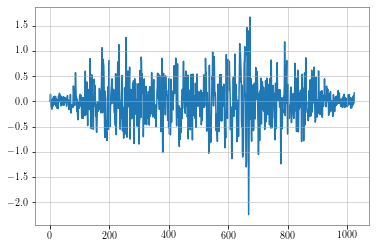

In [221]:
fig, ax = plt.subplots()
ax.plot(whitened_h_td_all3[0][0])

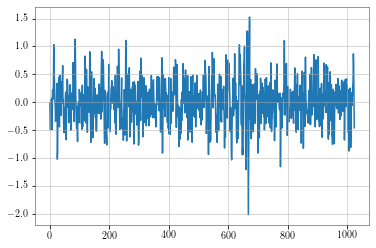

In [222]:
fig, ax = plt.subplots()
ax.plot(whitened_h_td_all[0][0])

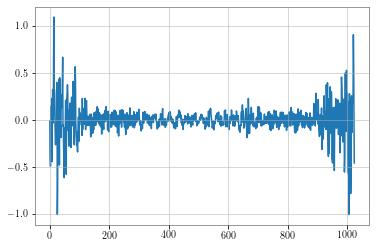

In [226]:
fig, ax = plt.subplots()
ax.plot(whitened_h_td_all[0][0] - np.roll(whitened_h_td_all3[0][0],-1))

In [49]:
params_dir = model_dir#"../vitamin_c/params_files"
params_file = os.path.join(params_dir,'params.json')                                                                                                                 
bounds_file = os.path.join(params_dir,'bounds.json')                                                                                                                 
#fixed_vals_file = os.path.join(params_dir,'fixed_vals.json')                                                                                                         
                                                                                                                                                                         
EPS = 1e-3                                                                                                                                                           
                                                                                                                                                                         
# Load parameters files                                                                                                                                              
with open(params_file, 'r') as fp:                                                                                                                                   
    params = json.load(fp)                                                                                                                                           
with open(bounds_file, 'r') as fp:                                                                                                                                   
    bounds = json.load(fp)                                                                                                                                           
#with open(fixed_vals_file, 'r') as fp:                                                                                                                               
#    fixed_vals = json.load(fp) 
    
params["ref_geocent_time"] = start_time + 0.5

In [50]:
params, bounds, masks, fixed_vals = get_params(params, bounds, fixed_vals = None)

... converted RA bounds to hour angle
[False, False, True, False, False, False, False, False, False, False, False, False, False, True, True]
[True, True, False, True, True, True, True, True, True, True, True, True, True, False, False]
[ 3  4  0  5  6  7  8  9 10 11 12 13 14  1  2]
['mass_1', 'mass_2', 'luminosity_distance', 'geocent_time', 'phase', 'theta_jn', 'psi', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'ra', 'dec']
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False] []
[False, False, True, True, True, True, True, True, True, True, True, True, True, True, True] [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False] [0]
[False, True, False, False, False, False, False, False, False, False, False, False, False, False, False] [1]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [51]:
train_dataset = load_data_fit.DataLoader(params["train_set_dir"],params = params,bounds = bounds, masks = masks,fixed_vals = fixed_vals, chunk_batch = 2)

In [52]:
test_dataset = load_data_fit.DataLoader(params["test_set_dir"],params = params,bounds = bounds, masks = masks,fixed_vals = fixed_vals, chunk_batch = 100, test_set = True)

In [53]:
train_dataset.load_next_chunk()

/home/joseph.bayley/public_html/CBC/vitamin_O4MDC/vitamin_c_run2_1024_16ynorm/load_data_fit.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data['x_data'] = np.concatenate(np.array(data['x_data']), axis=0).squeeze()
/home/joseph.bayley/public_html/CBC/vitamin_O4MDC/vitamin_c_run2_1024_16ynorm/load_data_fit.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data['y_data_noisefree'] = np.transpose(np.concatenate(np.array(data['y_data_noisefree']), axis=0),[0,2,1])
/home/joseph.bayley/public_html/CBC/vitamin_O4MDC/vitamin_c_run2_1024_16ynorm/load

load_time chunk 0: 2.2157914638519287


In [54]:
test_dataset.load_next_chunk()

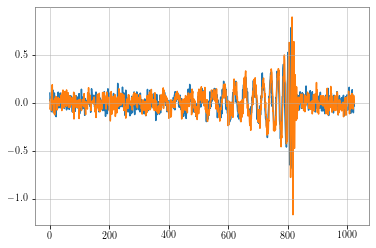

In [72]:
ind = 7
fig, ax = plt.subplots()
ax.plot(train_dataset.Y_noisefree[ind][:,0])
ax.plot(-train_dataset.Y_noisefree[ind][:,1])

In [61]:
test_dataset.X[ind]

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0.9890115 , 0.54954475, 0.2814473 , 0.61829495,
       0.3751709 , 0.48268047, 0.097044  , 0.11595071,
       0.6273917 , 0.7523755 , 0.597055  , 0.9907217 ,
       0.47035074, 0.44446948, 0.17934969], dtype=float32)>

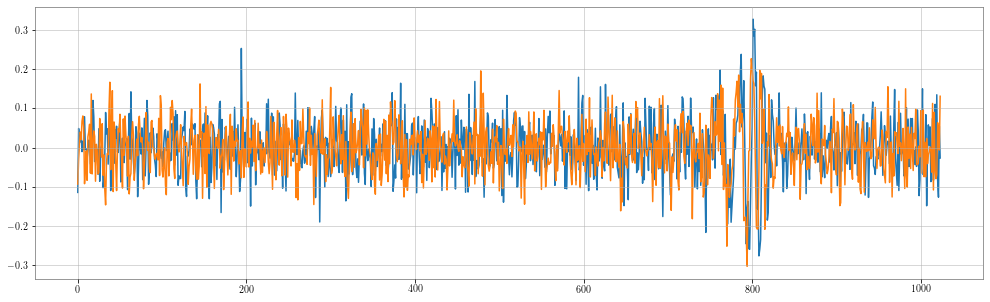

In [64]:
ind = 1
fig, ax = plt.subplots(figsize = (17,5))
ax.plot(test_dataset.Y_noisy[ind][:,0])
ax.plot(-test_dataset.Y_noisy[ind][:,1])

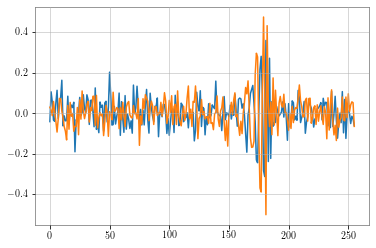

In [24]:
fig, ax = plt.subplots()
ax.plot(tf.keras.activations.tanh(train_dataset.Y_noisefree[3][:,0]))
ax.plot(tf.keras.activations.tanh(train_dataset.Y_noisefree[3][:,1]))